
**Link:** https://www.kaggle.com/datasets/cpluzshrijayan/milkquality

**About dataset:**
This dataset is manually collected from observations. It helps us to build machine learning models to predict the quality of milk.
This dataset consists of 7 independent variables ie pH, Temperature, Taste, Odor, Fat, Turbidity, and Color.
Generally, the Grade or Quality of the milk depends on these parameters. These parameters play a vital role in the predictive analysis of the milk.

**Usage:**
The target variable is nothing but the Grade of the milk. It can be

Target

Low (Bad)

Medium (Moderate)

High (Good)

If Taste, Odor, Fat, and Turbidity are satisfied with optimal conditions then they will assign 1 otherwise 0.
Temperature and ph are given their actual values in the dataset.


**Column Details:**  
**pH**  
This Column defines PH alus of the milk which ranges from 3 to 9.5  

**Temprature**  
This Column defines Temprature of the milk which ranges from 34'C to 90'C  

**Taste**  
This Column defines Taste of the milk which is categorical data 0 (Bad) or 1 (Good)  

**Odor**  
This Column defines Odor of the milk which is categorical data 0 (Bad) or 1 (Good)  

**Fat**  
This  Column defines Odor of the milk which is categorical data 0 (Low) or 1 (High)  

**Turbidity**  
This Column defines Turbidity of the milk which is categorical data 0 (Low) or 1 (High)   

**Colour**  
This Column defines Colour of the milk which ranges from 240 to 255  

**Grade**  
This Column defines Grade (Target) of the milk which is categorical data Where Low (Bad) or Medium (Moderate) High (Good)

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 100)
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import altair as alt
alt.renderers.enable("default")

no_seed = 572

import warnings
warnings.filterwarnings("ignore")

%load_ext rpy2.ipython

In [2]:
df_raw = pd.read_csv('data/milknew_raw.csv')
# df_raw = df_raw.reset_index()
print(df_raw.shape)
df_raw.head(3)

(1059, 8)


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low


# EDA

## general: info(), describe(), count()

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1059 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1059 non-null   int64  
 3   Odor        1059 non-null   int64  
 4   Fat         1059 non-null   int64  
 5   Turbidity   1059 non-null   int64  
 6   Colour      1059 non-null   int64  
 7   Grade       1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB


In [4]:
df_raw.describe()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,6.630123,44.226629,0.546742,0.432483,0.671388,0.491029,251.840415
std,1.399679,10.098364,0.498046,0.495655,0.469930,0.500156,4.307424
min,3.000000,34.000000,0.000000,0.000000,0.000000,0.000000,240.000000
25%,6.500000,38.000000,0.000000,0.000000,0.000000,0.000000,250.000000
50%,6.700000,41.000000,1.000000,0.000000,1.000000,0.000000,255.000000
75%,6.800000,45.000000,1.000000,1.000000,1.000000,1.000000,255.000000
max,9.500000,90.000000,1.000000,1.000000,1.000000,1.000000,255.000000


In [5]:
df_raw.Grade.value_counts(dropna=False)

low       429
medium    374
high      256
Name: Grade, dtype: int64

## Label

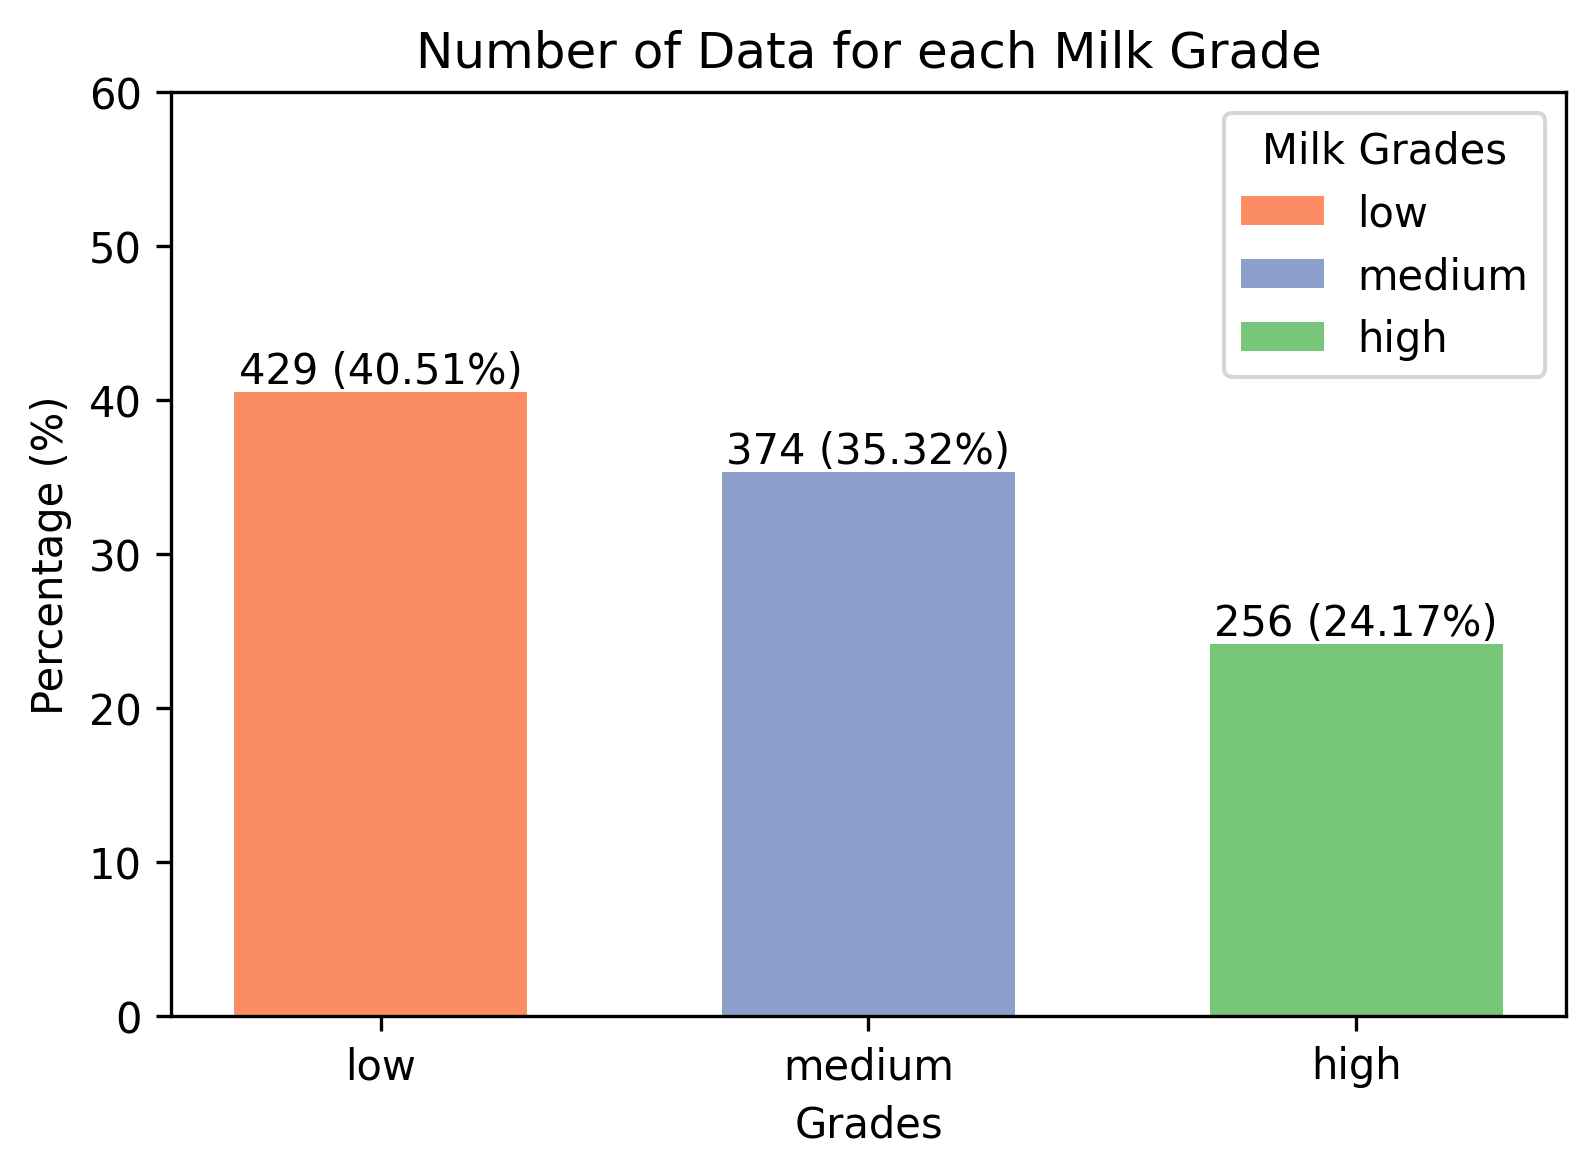

In [130]:
df_grade_norm = pd.DataFrame(df_raw.Grade.value_counts(dropna=False, normalize=True))
df_grade = pd.DataFrame(df_raw.Grade.value_counts(dropna=False))

df_grade_cb = pd.concat([df_grade, df_grade_norm], axis=1).reset_index()
df_grade_cb.columns = ['index', 'count', 'count_pct']
df_grade_cb['plot_text'] = df_grade_cb['count'].astype(str) + ' (' + round(df_grade_cb['count_pct']*100, 2).astype(str)+"%)"


# Define colors for each category
colors = ['#fc8d62', '#8da0cb', '#78c679']

# Plotting the bar chart with colors
plt.figure(figsize=(6, 4), facecolor='none', dpi=300)
bars = plt.bar(df_grade_cb['index'], df_grade_cb['count_pct'] * 100, color=colors, width=0.6)
plt.xlabel('Grades')
plt.ylabel('Percentage (%)')
plt.title('Number of Data for each Milk Grade')

# Add legend with labels from 'index' column
plt.legend(bars, df_grade_cb['index'], title='Milk Grades')

# Set y-axis limit to 0-100 for percentages
plt.ylim(0, 60)

# Add text labels above each bar with raw values
for bar, value in zip(bars, df_grade_cb['plot_text']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{value}', ha='center', va='bottom', color='black')

# Show the plot
plt.show()


## Correlation

In [6]:
df_raw.loc[df_raw['Grade']=='low', 'Grade_enc'] = 0
df_raw.loc[df_raw['Grade']=='medium', 'Grade_enc'] = 1
df_raw.loc[df_raw['Grade']=='high', 'Grade_enc'] = 2
df_raw['Grade_enc'] = df_raw['Grade_enc'].astype(int)

In [7]:
def plot_correlation_heat_alt(df_raw, method='pearson'):
    # Melt the DataFrame to long format for Altair
    corr_df = df_raw.corr(method)
    corr_long = pd.melt(corr_df.reset_index(), id_vars='index')

    # Rename the columns
    corr_long.columns = ['variable1', 'variable2', 'correlation']

    # Create the heatmap using Altair
    heatmap = alt.Chart(corr_long).mark_rect().encode(
        x='variable1:O',
        y='variable2:O',
        color=alt.Color('correlation:Q', scale=alt.Scale(scheme='blueorange', domainMin=-1, domainMax=1)),
        tooltip=['variable1:N', 'variable2:N', 'correlation:Q']
    ).properties(
        title=f'Correlation Heatmap ({method})',
        height=300,
        width=300,
    )

    # Add text annotations for correlation values
    text = alt.Chart(corr_long).mark_text(baseline='middle').encode(
        x='variable1:O',
        y='variable2:O',
        text=alt.Text('correlation:Q', format='.2f'),
        color=alt.condition(
            alt.datum.correlation > 0.5,
            alt.value('white'),
            alt.value('black')
        )
    )

    # Combine the heatmap and text annotations
    heatmap_with_text = heatmap + text
    display(heatmap_with_text)

In [8]:
plot_correlation_heat_alt(df_raw, method='pearson')


alt.LayerChart(...)

In [9]:
plot_correlation_heat_alt(df_raw, method='spearman')

alt.LayerChart(...)

In [10]:
def plot_correlation_heat(df_raw, method='pearson'):

    # Melt the DataFrame to long format for Altair
    corr_df = df_raw.corr(method)
    corr_mat = np.matrix(corr_df)
    # Plot the heatmap using Matplotlib
    plt.figure(figsize=(6, 4))
    heatmap = plt.imshow(corr_df, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(heatmap, label='Correlation')

    # Set axis labels
    plt.xticks(np.arange(len(corr_df.columns)), corr_df.columns, rotation=45)
    plt.yticks(np.arange(len(corr_df.columns)), corr_df.columns)

    # Display the correlation values in each cell
    for i in range(len(corr_df.columns)):
        for j in range(len(corr_df.columns)):
            plt.text(j, i, f'{corr_mat[i, j]:.2f}', ha='center', va='center', color='black' if abs(corr_mat[i, j]) < 0.5 else 'white')

    # Set plot title
    plt.title('Correlation Heatmap')

    # Show the plot
    plt.show()

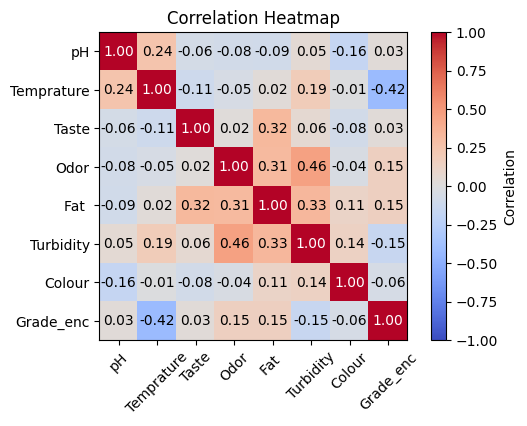

In [11]:
plot_correlation_heat(df_raw, method='pearson')


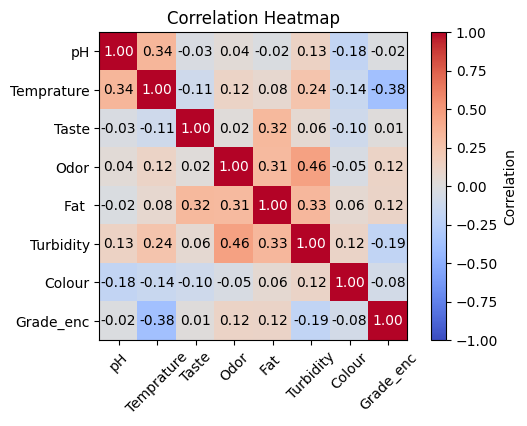

In [12]:
plot_correlation_heat(df_raw, method='spearman')

## Distribution

In [13]:
df_raw_melt = df_raw.drop(columns='Grade_enc').melt(id_vars=["Grade"])
df_raw_melt.head(3)

,Grade,variable,value
0,high,pH,6.6
1,high,pH,6.6
2,low,pH,8.5


Keep up to date with changes at https://www.tidyverse.org/blog/


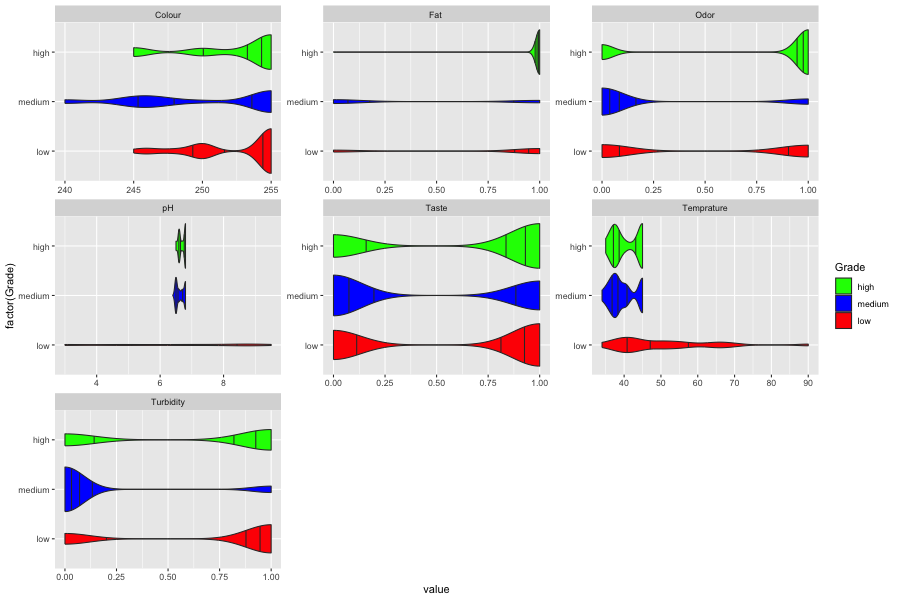

In [14]:
%%R -i df_raw_melt -w 900 -h 600

library(ggplot2)

sort_grade <- c("high", "medium",  "low")
df_raw_melt$Grade <- factor(df_raw_melt$Grade, levels = rev(sort_grade))

ggplot(df_raw_melt, aes(x = value, y=factor(Grade), fill = Grade)) +
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75)) + 
    facet_wrap(~variable, scales = "free", ncol = 3) +
    scale_fill_manual(values = c("high" = "green", "medium" = "blue", "low"="red"),
                     breaks = sort_grade)


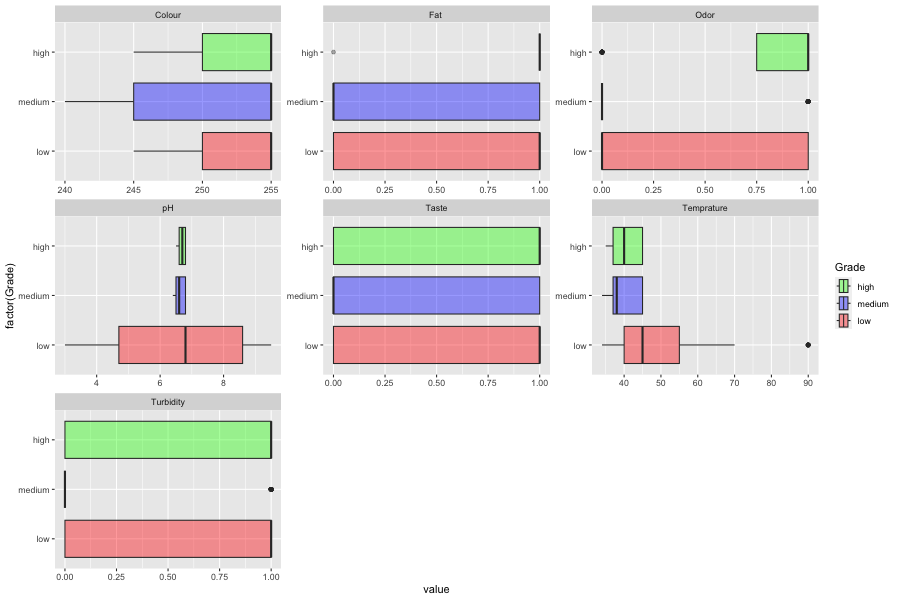

In [15]:
%%R -i df_raw_melt -w 900 -h 600

library(ggplot2)
library(forcats)


sort_grade <- c("high", "medium",  "low")
df_raw_melt$Grade <- factor(df_raw_melt$Grade, levels = rev(sort_grade))

g1 = ggplot(df_raw_melt, aes(x=value, y=factor(Grade), fill=Grade)) + 
        geom_boxplot(alpha=0.4) +
        facet_wrap(~variable, scales="free", ncol=3) +
        scale_fill_manual(values = c("high" = "green", "medium" = "blue", "low" = "red"),
                     breaks = sort_grade)
g1

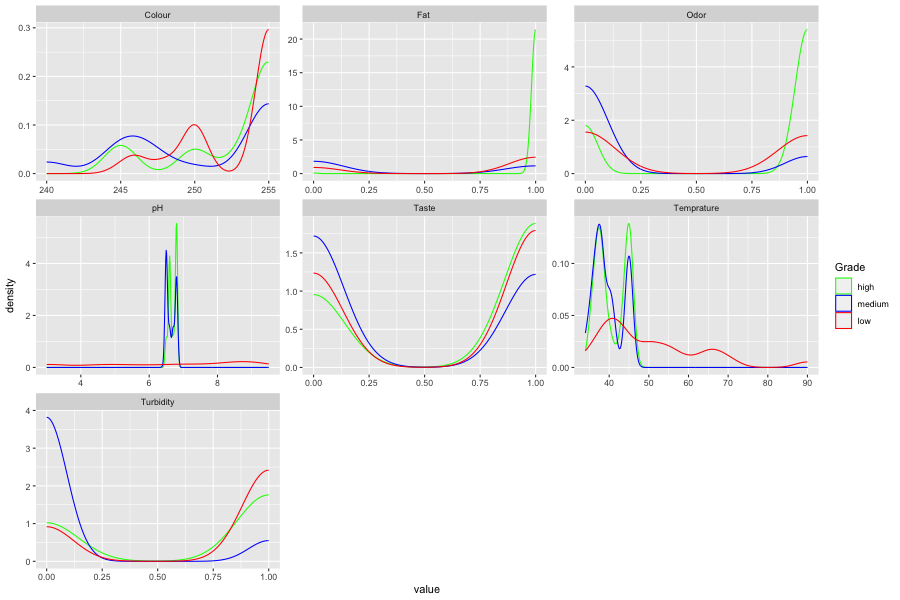

In [16]:
%%R -i df_raw_melt -w 900 -h 600

library(ggplot2)

sort_grade <- c("high", "medium",  "low")
df_raw_melt$Grade <- factor(df_raw_melt$Grade, levels = sort_grade)

g1 = ggplot(df_raw_melt, aes(x=value, color=Grade)) + 
        geom_density(alpha=0.4, position = "identity") +
        facet_wrap(~variable, scales="free", ncol=3) +
        scale_color_manual(values = c("high" = "green", "medium" = "blue", "low" = "red"))
g1

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


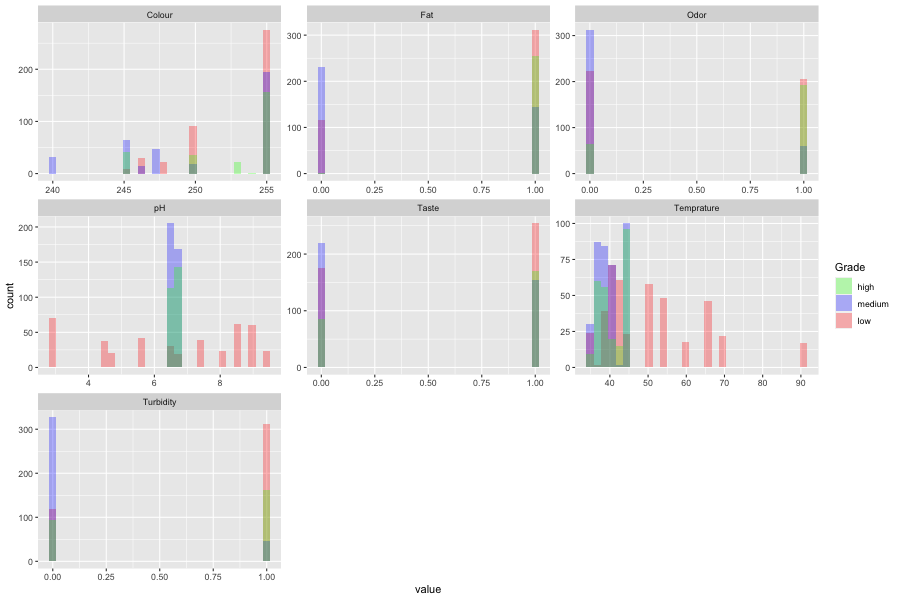

In [24]:
%%R -i df_raw_melt -w 900 -h 600

library(ggplot2)

sort_grade <- c("high", "medium",  "low")
df_raw_melt$Grade <- factor(df_raw_melt$Grade, levels = rev(sort_grade))

g2 = ggplot(df_raw_melt, aes(x=value, fill=Grade)) + 
        geom_histogram(alpha=0.3, position = "identity") +
        facet_wrap(~variable, scales="free", ncol=3) +
        scale_fill_manual(values = c("high" = "green", "medium" = "blue", "low" = "red"),
                          breaks = sort_grade)
g2


## Scatter plot

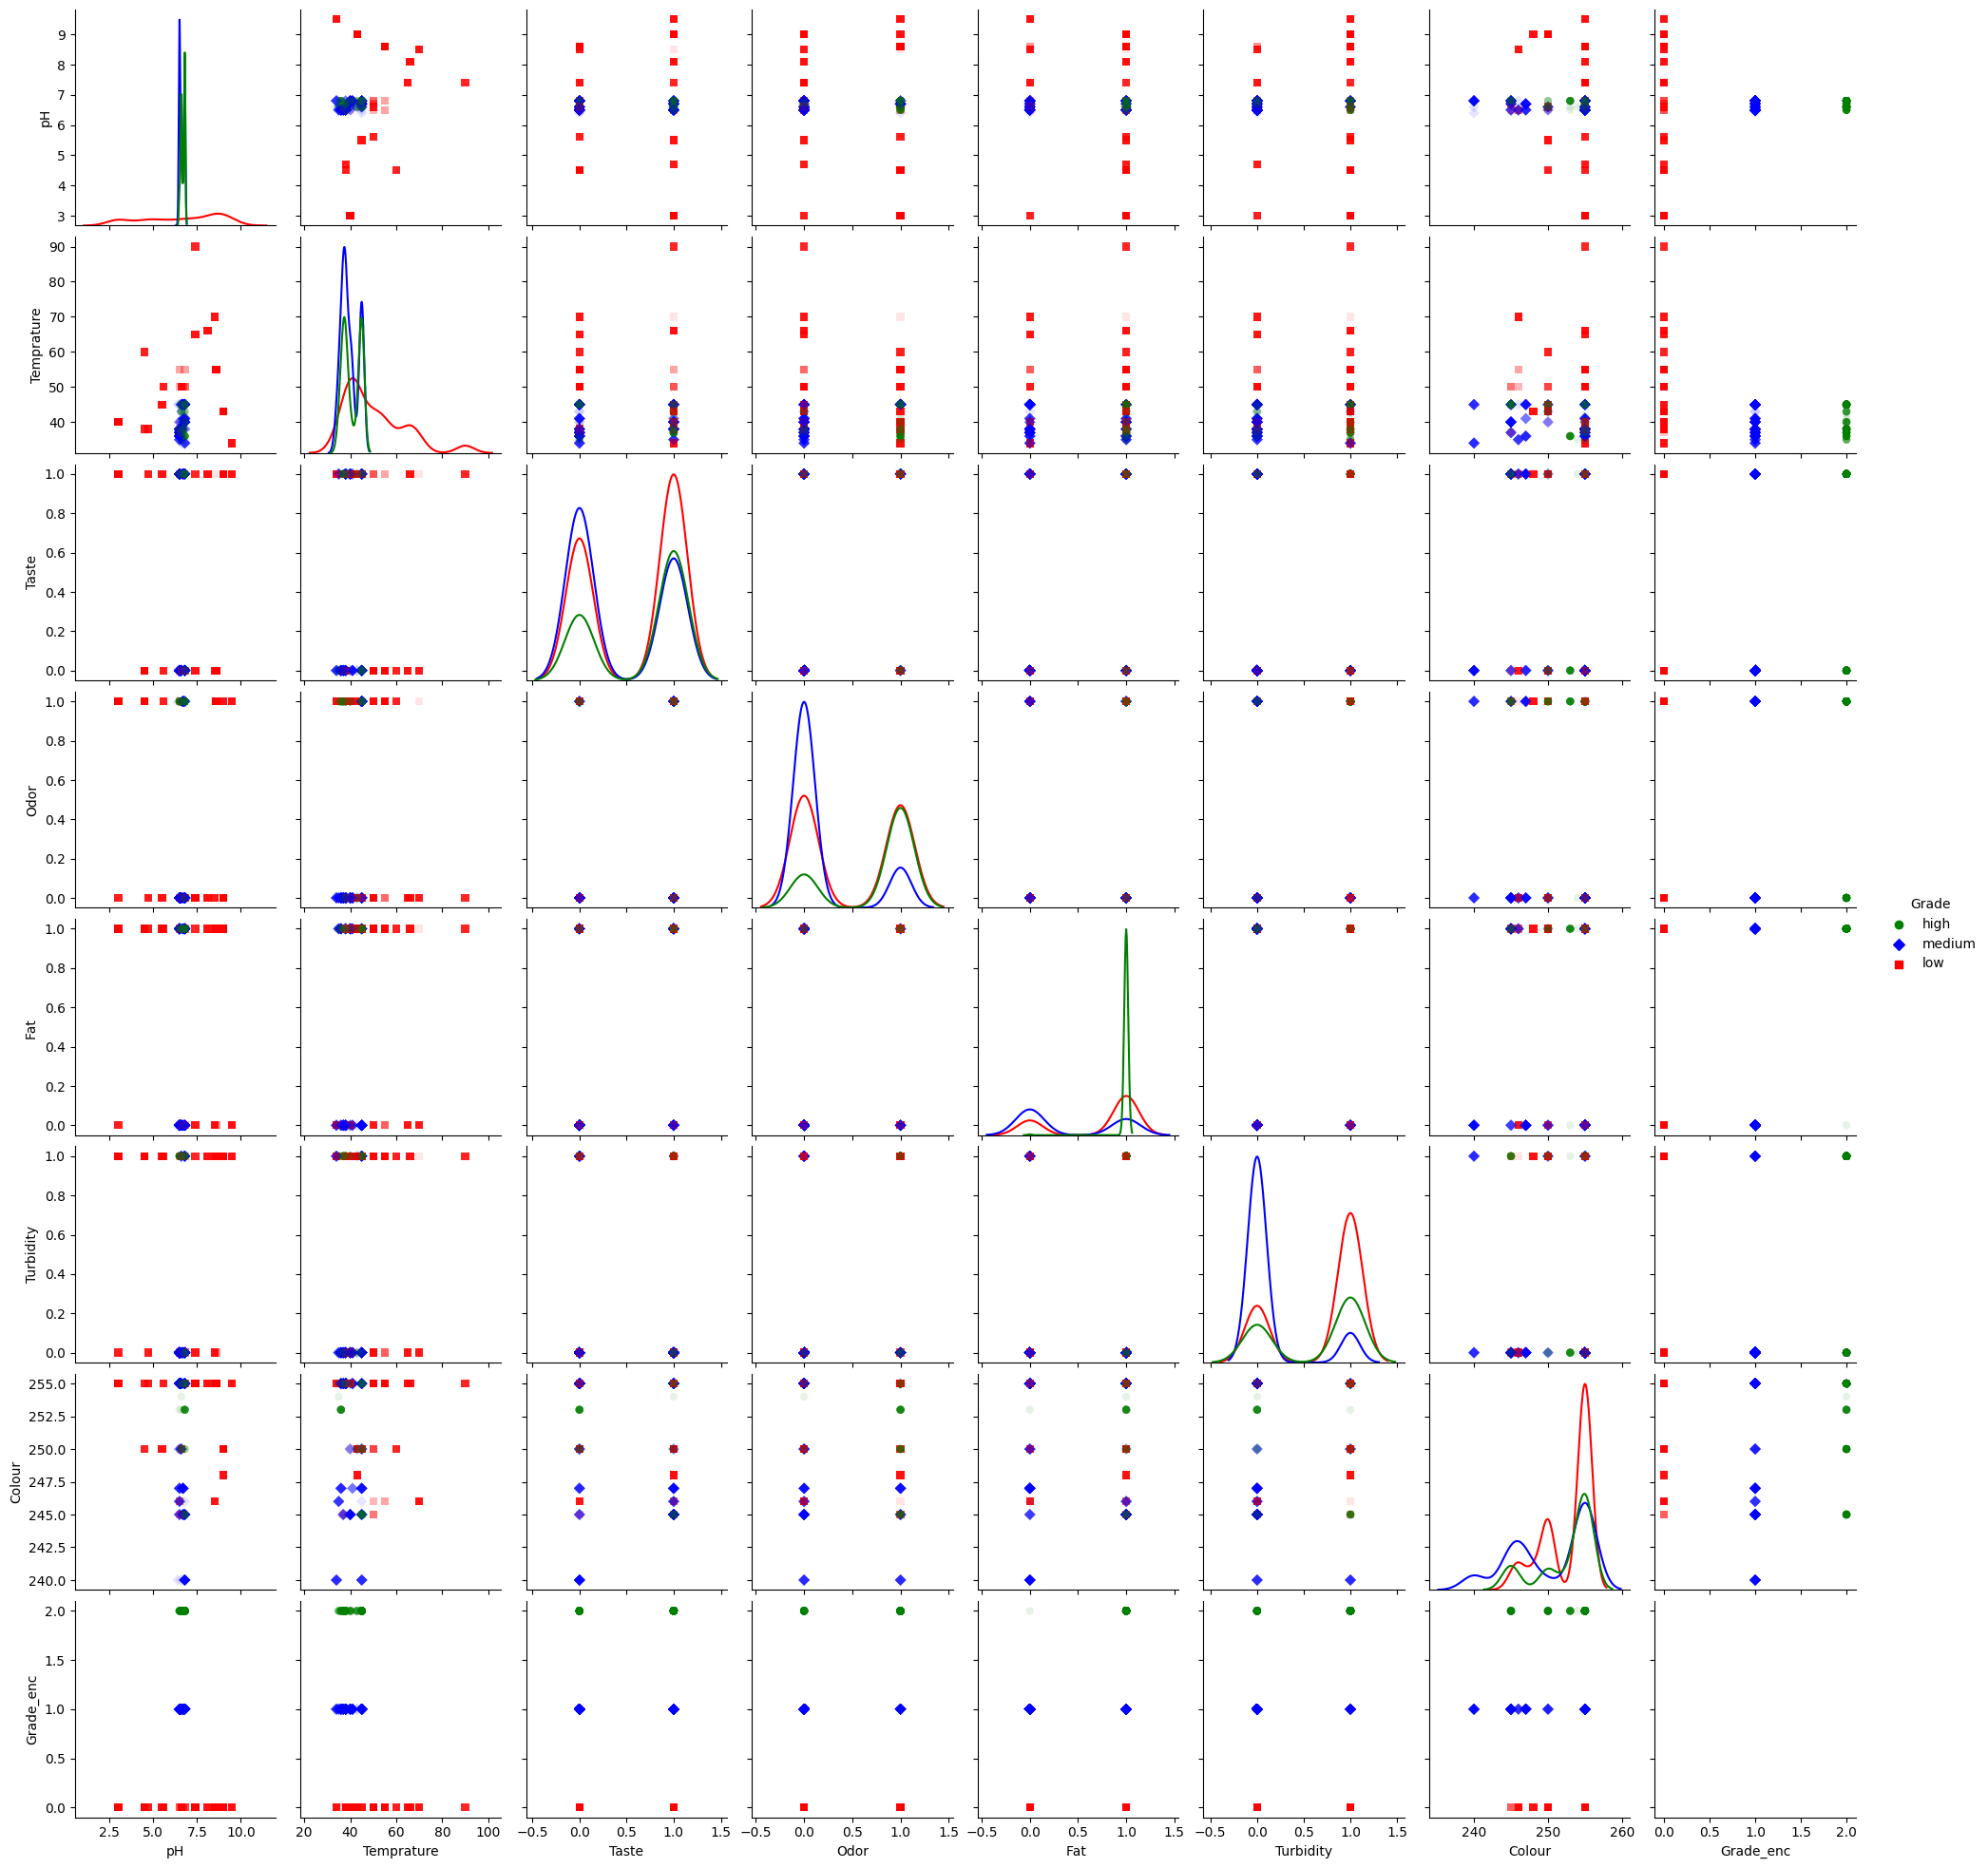

In [41]:
sort_grade = ["high", "medium", "low"]


custom_colors = {"high": "green", "medium": "blue", "low": "red"}

sns.pairplot(df_raw, hue="Grade", markers=["o", "s", "D"],
            palette=custom_colors, plot_kws={'alpha': 0.1, 'edgecolor': 'None'},
            diag_kws={'fill': False}, hue_order=sort_grade)
plt.show()

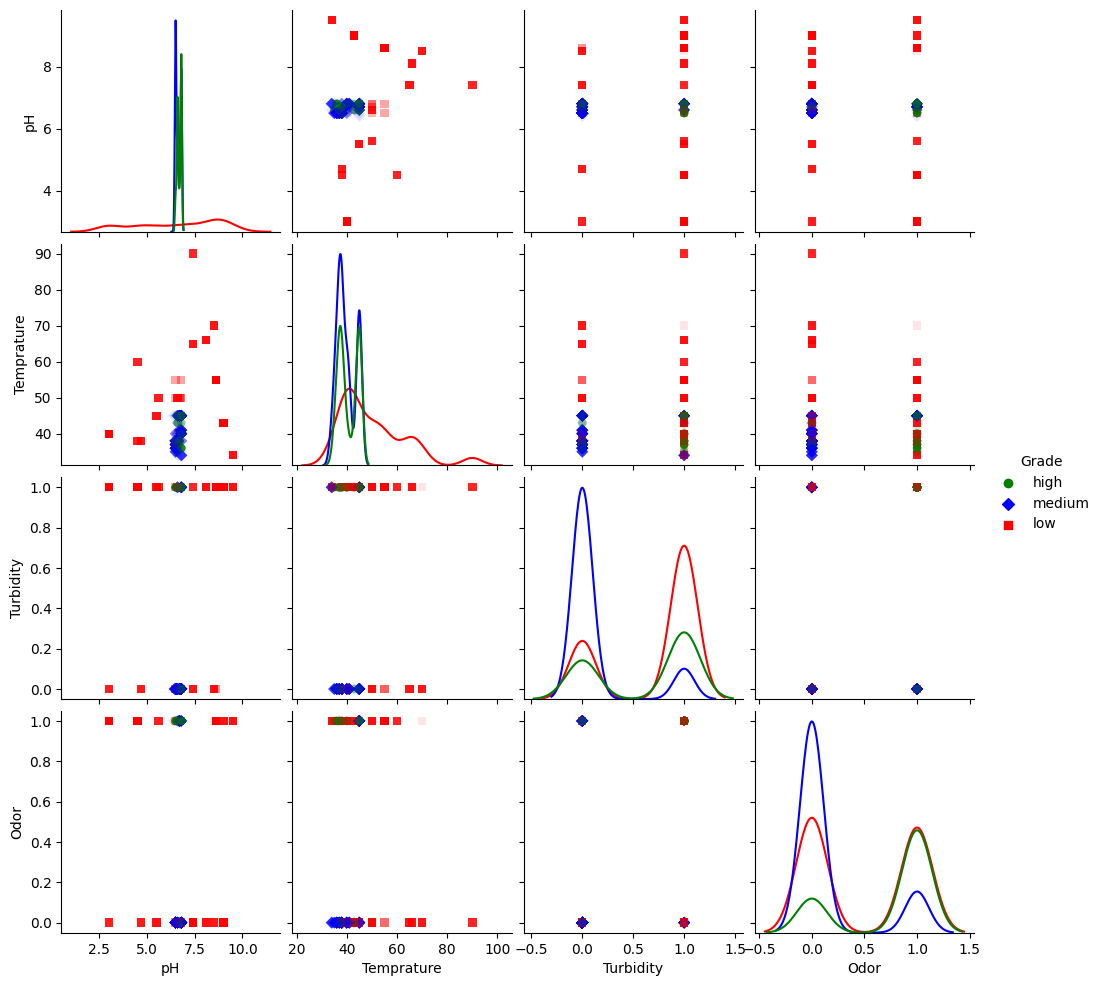

In [43]:
# zoom-in
cols_selected = ['Grade', 'pH', 'Temprature', 'Turbidity', 'Odor']
sns.pairplot(df_raw[cols_selected], hue="Grade", markers=["o", "s", "D"],
            palette=custom_colors, plot_kws={'alpha': 0.1, 'edgecolor': 'None'},
            diag_kws={'fill': False},  hue_order=sort_grade)
plt.show()

# Groupby Grade

In [30]:
df_stast_groupby = df_raw.drop(columns='Grade_enc').groupby('Grade').describe(include='all').T[['high', 'medium', 'low']]
df_stast_groupby

Grade                   high      medium         low
pH         count  256.000000  374.000000  429.000000
           mean     6.692578    6.635027    6.588578
           std      0.108752    0.130899    2.194712
           min      6.500000    6.400000    3.000000
           25%      6.600000    6.500000    4.700000
           50%      6.700000    6.600000    6.800000
           75%      6.800000    6.800000    8.600000
           max      6.800000    6.800000    9.500000
Temprature count  256.000000  374.000000  429.000000
           mean    40.648438   39.721925   50.289044
           std      3.739749    3.613751   13.043794
           min     35.000000   34.000000   34.000000
           25%     37.000000   37.000000   40.000000
           50%     40.000000   38.000000   45.000000
           75%     45.000000   45.000000   55.000000
           max     45.000000   45.000000   90.000000
Taste      count  256.000000  374.000000  429.000000
           mean     0.664062    0.414439    0.592075
           std      0.473242    0.493285    0.492023
           min      0.000000    0.000000    0.000000
           25%      0.000000    0.000000    0.000000
           50%      1.000000    0.000000    1.000000
           75%      1.000000    1.000000    1.000000
           max      1.000000    1.000000    1.000000
Odor       count  256.000000  374.000000  429.000000
           mean     0.750000    0.163102    0.477855
           std      0.433861    0.369953    0.500093
           min      0.000000    0.000000    0.000000
           25%      0.750000    0.000000    0.000000
           50%      1.000000    0.000000    0.000000
           75%      1.000000    0.000000    1.000000
           max      1.000000    1.000000    1.000000
Fat        count  256.000000  374.000000  429.000000
           mean     0.996094    0.385027    0.727273
           std      0.062500    0.487253    0.445882
           min      0.000000    0.000000    0.000000
           25%      1.000000    0.000000    0.000000
           50%      1.000000    0.000000    1.000000
           75%      1.000000    1.000000    1.000000
           max      1.000000    1.000000    1.000000
Turbidity  count  256.000000  374.000000  429.000000
           mean     0.632812    0.125668    0.724942
           std      0.482982    0.331919    0.447065
           min      0.000000    0.000000    0.000000
           25%      0.000000    0.000000    0.000000
           50%      1.000000    0.000000    1.000000
           75%      1.000000    0.000000    1.000000
           max      1.000000    1.000000    1.000000
Colour     count  256.000000  374.000000  429.000000
           mean   252.539062  250.336898  252.734266
           std      3.711989    5.262430    3.233046
           min    245.000000  240.000000  245.000000
           25%    250.000000  245.000000  250.000000
           50%    255.000000  255.000000  255.000000
           75%    255.000000  255.000000  255.000000
           max    255.000000  255.000000  255.000000